# Confidence limits <a class="notoc"></a>
### Christian Holm Christensen <a class="notoc"></a>

## Setup
First, some setup code 

In [1]:
%matplotlib inline
import numpy as np
import sympy as sy
import scipy as sp
import scipy.stats 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = [8.,8.]
rcParams['image.cmap'] = 'cividis'
rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
rcParams['font.family'] = ['serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.formatter.use_mathtext'] = True
sy.init_printing()
np.random.seed(12345)

The function below is needed to expand 

$$\log\left(\prod_{i=1}^{N}\ldots\right) \rightarrow 
\sum_{i=1}^{N} \log(\ldots)\quad,$$

for older versions ($<1.5$) of _SymPy_.   Just ignore it - in newer version this is the same as 

    expr.expand(log=True,force=True) 
    

In [2]:
def concrete_expand_log(expr, first_call=True,**kwargs):
    """Force expansion of `log(Product(...))"""
    from sympy import __version__ as syvers
    try:
        if float(syvers) >= 1.5:
            return expr.expand(log=True,force=True,**kwargs)
    except:
        pass
    
    from sympy.concrete.products import Product
    from sympy.concrete.summations import Sum
    from sympy.functions.elementary.exponential import log

    if first_call:
        expr = expr.expand(log=True,**kwargs)
    if expr.args is ():
        return expr
    if expr.func is log and expr.args[0].func is Product:
            return Sum(log(expr.args[0].args[0]), 
                       *expr.args[0].args[1:])
    return expr.func(*map(lambda x:
                          concrete_expand_log(x, False,**kwargs),
                          expr.args))

# $q\bar{q}$ Scattering
## The problem

### The probability density function and sampling 

We have the function 

$$f(x;\alpha,\beta) = 1 + \alpha x + \beta x^2\quad x\in[-0.95,0.95]\quad,$$

which we want to sample.  However, this function is not normalised off-hand, so we evaluate the integral over the domain 

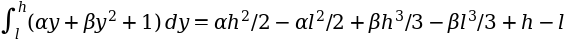

In [3]:
nl = -.95
nh = .95
x, y, alpha, beta, l, h = sy.symbols('x y alpha beta l h',real=True)
f = 1 + alpha * y + beta * y**2
i = f.integrate((y,l,h)).simplify()
sy.Eq(sy.Integral(f,(y,l,h)),i)

and thus to have a properly normalised probability density function (PDF), we define 

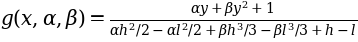

In [4]:
g = f / i
fg = sy.Function('g')
sy.Eq(fg(x,alpha,beta),g)

To sample this PDF, we want to find the cumulative density function (CDF)

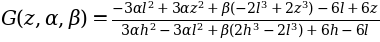

In [5]:
z = sy.symbols('z',real=True)
G = g.integrate((y,l,z)).simplify().collect(beta)
fG = sy.Function('G')
sy.Eq(fG(z,alpha,beta),G)

We solve 

$$ G(z;\alpha,\beta) - y = 0\quad,$$ 

to find the inverse $G^{-1}$ CDF.  This function can be used to sample the PDF by sampling a uniform distribution $r\sim U[0,1)$ and evaluating $G^{-1}(r;\alpha,\beta)$

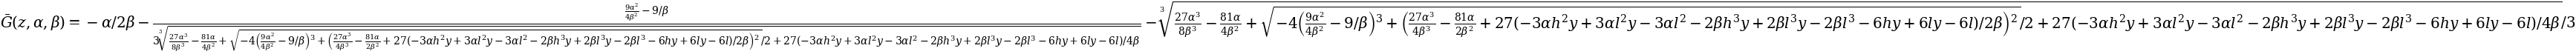

In [6]:
s = sy.solve(y-G,z)
fGm1 = sy.Function('Gbar')
Gm1 = s[0]
sy.Eq(fGm1(z,alpha,beta),Gm1)

Let us plot these three functions for $\alpha=0.5$, $\beta=0.5$. 

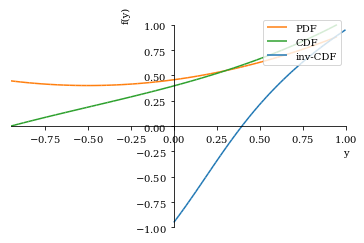

In [7]:
values = {alpha:.5,beta:.5,l:nl,h:nh,z:y}
p = sy.plot(g.subs(values), G.subs(values), (y,nl,nh),show=False)
p.append(sy.plot(Gm1.subs(values),(y,0,1),show=False)[0])
p[0].label='PDF'
p[1].label='CDF'
p[2].label='inv-CDF'
p[0].line_color = 'C1'
p[1].line_color = 'C2'
p.legend = True
p.show()

### Maximum likelihood estimates of parameters 

We've already seen in a previous exercise, that we cannot find analytic estimators for the parameters.  Thus, our next step is to do numerical calculations. 

## Numerical evaluation 

We will use `lambdify` to convert our expression to numerical functions that we may evaluate 

In [38]:
var = {l:nl,h:nh}
pdf = sy.lambdify((y,alpha,beta),g.subs(var).simplify())
invcdf = sy.lambdify((y,alpha,beta),Gm1.subs(var).simplify())

Let us sample the PDF via our inverse CDF.

In [9]:
talpha = .5
tbeta = .5
data = invcdf(np.random.uniform(size=2000),talpha,tbeta)

We write a function to make a histogram of our data.  This differs from the _NumPy_ histogram in that we pre-compute the bin centres and widths, as well as the uncertainties 

In [10]:
def histogram(data,bins='auto'):
    from numpy import histogram as hist 
    from numpy import diff, sqrt
    from matplotlib.pyplot import errorbar, gca
    
    class _h: 
        def __init__(self,data,bins):
            self.y, self.b = hist(data,bins,density=True)
            self.x = (self.b[1:]+self.b[:-1])/2
            self.w = diff(self.b)
            self.e = sqrt(self.y/len(data)/self.w)
        def plot(self,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.errorbar(self.x,self.y,self.e,self.w/2,*args,**kwargs)
    
    return _h(data,bins)

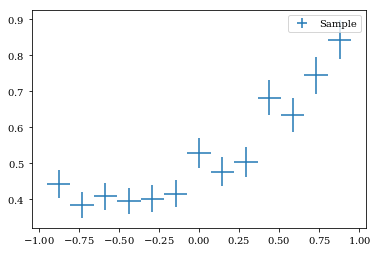

In [11]:
hist = histogram(data)
hist.plot(fmt='none',label='Sample')
plt.legend();

From this sample, we can estimate the parameters using a maximum likelihood estimates as we did in a previous exercise. 

### Numerical maximum likelihood estimates

We define a general function to do a maximum likelihood fit of a PDF to data. 

In [12]:
def mlefit(f,data,*args,**kwargs):
    from numpy import log, sqrt, errstate
    from scipy.optimize import minimize 
    from matplotlib.pyplot import plot, gca
    
    class _mlef:
        def __init__(self,f,data,*args,**kwargs):
            self.f    = f
            opt       = minimize(lambda args: self.llh(args,data),
                                 *args,**kwargs)
            self.p    = opt.x
            self.cov  = opt.hess_inv
            self.e    = sqrt(self.cov.diagonal())
            self.nllh = -opt.fun
            
        def plot(self,x,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.plot(x,self.f(x,*self.p),*args,**kwargs)
        
        def llh(self,args,data=data):
            with errstate(invalid='ignore'):
                return -log(f(data,*args)).sum(axis=0)
            
        def __str__(self):
            txt = f'Maximum log-likelihood: {-self.nllh:.3f}\n'
            txt += 'Parameters, uncertainties, covariance:\n'
            txt += '\n'.join([f' p{i}: {p:.2f} +/- {e:.2f}\t' 
                              + '\t'.join([f'{c:.2f}' for c in self.cov[i]])
                              for i,(p,e) in enumerate(zip(self.p,self.e))])
            return txt
        
    return _mlef(f,data,*args,**kwargs)

We use this evaluate the log-likehood given the data.  We will use our `lambdify`d PDF from above to do so. 

Maximum log-likelihood: 1216.938
Parameters, uncertainties, covariance:
 p0: 0.51 +/- 0.05	0.00	0.00
 p1: 0.46 +/- 0.11	0.00	0.01


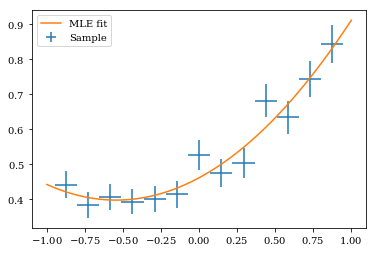

In [13]:
mle = mlefit(pdf,data,(0,0))
hist.plot(fmt='none',label='Sample')
xrng = np.linspace(-1,1,100)
mle.plot(xrng,label='MLE fit')
print(mle)
plt.legend();

### Least-squares estimates

Another way of estimating the parameters, is to fit the normalised function 

$$f(x;a,b,l) = \frac{1+ax+bx^2}{2l\left(\frac{b l^2}{3}+1\right)}\quad,$$ 

to our histogram.  Note, $l=0.95$ is fixed. 

We define a general function to do our least-squares fit 

In [14]:
def lsqfit(f,h,p0=None,sigma=None,*args,**kwargs):
    from numpy import sqrt, errstate
    from scipy.optimize import curve_fit
    from scipy.stats import chi2
    from matplotlib.pyplot import plot, gca
    
    class _lsqf:
        def __init__(self,f,h,p0,sigma,**kwargs):
            kwargs['absolute_sigma'] = kwargs.get('absolute_sigma',True) 
            self.f                   = f
            self.p, self.cov         = curve_fit(f,h.x,h.y,p0,sigma,*kwargs)
            self.e                   = sqrt(self.cov.diagonal())
            self.chi2                = (((h.y-f(h.x,*self.p))/h.e)**2).sum()
            self.nu                  = len(h.y)-len(self.p)
            self.pvalue              = chi2.sf(self.chi2,self.nu)
            
        def plot(self,x,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.plot(x,self.f(x,*self.p),*args,**kwargs)
        
        def __str__(self):
            txt =  f'chi^2/nu: {self.chi2:.2f}/{self.nu}={self.chi2/self.nu:.1f}\n'
            txt += f'p-value:  {self.pvalue*100:.1f}%\n'
            txt += 'Parameters, uncertainties, covariance:\n'
            txt += '\n'.join([f' p{i}: {p:.2} +/- {e:.1}\t' 
                              + '\t'.join([f'{c:.2}' for c in self.cov[i]])
                              for i,(p,e) in enumerate(zip(self.p,self.e))])
            return txt
        
    return _lsqf(f,h,p0,sigma,*args,**kwargs)

We perform the fit using our `lambdify`d PDF 

chi^2/nu: 8.12/11=0.7
p-value:  70.3%
Parameters, uncertainties, covariance:
 p0: 0.51 +/- 0.05	0.0027	0.0025
 p1: 0.49 +/- 0.1	0.0025	0.013


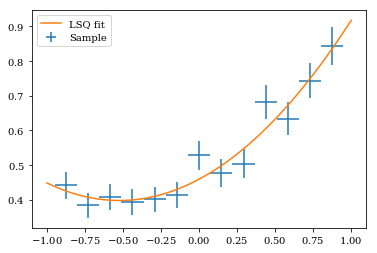

In [15]:
lsq = lsqfit(pdf,hist,(0,0),hist.e)
hist.plot(fmt='none',label='Sample')
lsq.plot(xrng,label='LSQ fit')
print(lsq)
plt.legend();


### Visualisation of results 

We plot 

- The histogram
- The PDF 
- The fitted function using maximum likelihood estimates (MLE)
- The fitted function using least-squares estimates (LSQ)
- The parameter values and uncertainties of both estimates 
- The $\chi^2/\nu$ and probability from the least squares fit

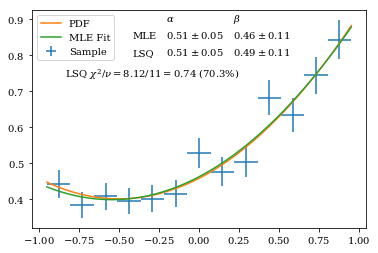

In [16]:
hist.plot(fmt='none',label='Sample')

xrng = np.linspace(-nl,nl,100)

plt.plot(xrng,pdf(xrng,talpha,tbeta),  label='PDF')
mle.plot(xrng,                         label='MLE Fit')
#lsq.plot(xrng,                         label='LSQ Fit')

ty = .95
at = plt.gca().transAxes
plt.text(.4,ty,r'$\alpha$',transform=at)
plt.text(.6,ty,r'$\beta$', transform=at)

for f,n in zip([mle,lsq],['MLE','LSQ']):    
    ty -= .08
    tx =  .3
    plt.text(tx,ty,f'{n:3s}',transform=at)
    tx += .1
    
    for p,e in zip(f.p,f.e):
        plt.text(tx,ty,fr'${p:.2f}\pm{e:.2f}$',transform=at)
        tx += .2

ty -= .1 
plt.text(.1,ty,r'LSQ $\chi^2/\nu={:.2f}/{}={:.2f}\ ({:.1f}\%)$'
         .format(lsq.chi2,lsq.nu,lsq.chi2/lsq.nu,lsq.pvalue*100),
         transform=at)

plt.legend();

The two different estimates are more or less the same - they are certainly compatible within uncertainties. 

## Estimating parameter uncertainties 
### Direct estimation from inverse Hessian

Above, we could estimate the parameter uncertainties because our minimisation method returns the inverse Hessian.  The Hessian of a log-likelihood function is given by 

$$ H = \begin{bmatrix} 
  h_{11} & \ldots & h_{1M}\\
  \vdots & \ddots & \vdots\\
  h_{M1} & \ldots & h_{MM}
  \end{bmatrix}
  \quad\text{with}\quad
  h_{ij} = \left.\frac{\partial^2 \log L(p)}{\partial p_i\partial p_j}\right|_{p=\hat{p}}$$

and the inverse is equal to the covariance 

$$H^{-1} = C = \begin{bmatrix} 
  c_{11} & \ldots & c_{1M}\\
  \vdots & \ddots & \vdots\\
  c_{M1} & \ldots & c_{MM}
  \end{bmatrix}
  \quad\text{with}\quad
  c_{ij} = \frac1N\sum_{k=1}^{N} \left(x_{i_k} - \overline{x_i}\right)\left(x_{j_k}-\overline{x_j}\right)\quad,$$
  
for $M$ parameters $p=(p_1,\ldots,p_M)$ and $N$ samples.  By definition, the uncertainty in the parameter $p_i$ is given by the square root of the variance of $p_i$ - i.e., 

$$\delta_{p_i} = \sqrt{c_{ii}}\quad.$$

### Numerical estimation 

If the minimisation method was not kind enough to give back the inverse Hessian (or covariance), then we are left with numerical means of trying to estimate the uncertainties.   

Suppose we made an observation and we fitted our model (the PDF) to it to obtain values of the parameters of the model.  From this alone we cannot estimate the uncertainties.  But, we can draw repeated samples from our PDF (with the found parameters), and then evaluate the variance in each parameter from these simulated samples.  Let us try this approach on the example above. 

We will set up a function that will take a PDF, the inverse CDF, and the found parameter values (seed values) of the PDF (and CDF), as well as the number of simulated samples to make, and the number of samples in each simulation. 

In [17]:
def simvar(pdf,invcdf,par,ntrial,nsamp):
    from numpy.random import uniform
    from numpy import array, zeros_like,atleast_1d
    
    z0 = zeros_like(par)
    p0 = atleast_1d(par)
    ps = array([mlefit(pdf,invcdf(uniform(0,1,size=nsamp),*p0),z0).p for _ in range(ntrial)])
    return ps

We run this for 500 simulations, each of size 2000.

In [18]:
ps = simvar(pdf,invcdf,mle.p,500,2000)

We can plot the distributions of the parameters 

$\alpha:$ Mean: $0.508$ Std.: $0.052$
$\beta:$ Mean: $0.472$ Std.: $0.105$


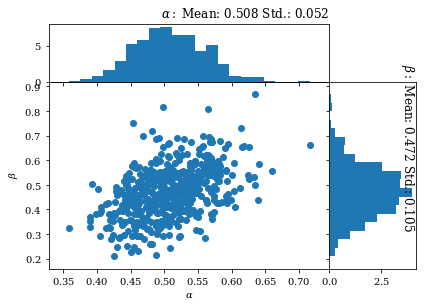

In [19]:
axc = plt.axes([.1, .1, .65,.65])
axt = plt.axes([.1, .75,.65,.2 ])
axr = plt.axes([.75,.1, .2, .65])
axc.scatter(ps[:,0],ps[:,1])
axc.set_xlabel(r'$\alpha$')
axc.set_ylabel(r'$\beta$')
for d,a,n,o,r in zip(ps.T,
                     [axt,axr],
                     [r'\alpha',r'\beta'],
                     ['vertical','horizontal'],
                     [0,-90]):
    m = d.mean()
    e = d.std()
    t = fr'${n}:$ Mean: ${m:.3f}$ Std.: ${e:.3f}$'
    print(t)
    
    a.hist(d,'auto',density=True,orientation=o)
    a.set_title(t, rotation=r,loc='right')

axt.set_xticklabels([])
axr.set_yticklabels([])
axt.set_xlim(axc.get_xlim())
axr.set_ylim(axc.get_ylim());

### Parametric bootstrapping 

For more on Bootstrap and Jackknife methods for estimating uncertainties, see [this note](https://cholmcc.gitlab.io/nbi-python/statistics/#Bootstrap). 


Here, we use a form of Bootstrap, which isn't exactly the one used for data.  We will simply take our distributions $\frac{dN}{d\alpha},\frac{dN}{d\beta}$ of $\alpha,\beta$, respectively, and integrate them in part to find the limits such that 

\begin{align*}
\frac{1-c}2 &= \int_{h}^{+\infty}dx\,\frac{dN}{dx}\\
\frac{1-c}2 &= \int_{-\infty}^{l}dx\,\frac{dN}{dx}\\
\end{align*}

for $x=\alpha,\beta$, and where $c$ is set by the number of $\sigma$ confidence levels we are interested in.  For $c=0.827$ Our $1\sigma$ confidence limits are then $l,h$.  If the distributions are properly normalised (or we normalise by the total integral), then, equivilantly 

\begin{align*}
c+\frac{1-c}2 = \frac{1+c}{2} &= \int_{-\infty}^{h}dx\,\frac{dN}{dx}\\
\frac{1-c}2   &= \int_{-\infty}^{l}dx\,\frac{dN}{dx}\\
\end{align*}



Here, we will implement two functions 

- The first `histcl` relies on the data being histogrammed. It then performs a cumulative integration over the histogram and finds the indexes in this distribution that fulfills the requirements above.  The returned confindence limits is then the bin centres at the found indexes.  
- The second `datacl` is somewhat simpler. It sorts the data points in ascending order, then calculates the indexes corresponding to $(1-c)/2$ and $(1+c)/2$ of the total number of elements, and returns the numbers at those position.  In fact, the function doesn't even sort the data - it simply generates an index vector that would sort the data. 

Each of them have different pros and cons.  The first method relies on the data being histogrammed with a fine enough binning to get accurate values.  On the other hand, it is not as susceptible to outliers and sparsely populated data as the other method.  The second method is fast and accurate if the data is densely distributed over the range.  If not, it may pick values that are far from the true $n\sigma$ boundary - simply because there are no data points near that boundary.  Below we will use both. 

In [20]:
def histcl(hist,c=0.6827):
    from numpy import cumsum, argwhere
    
    steps =  cumsum(hist.y)
    steps /= steps[-1] 
    lidx  =  argwhere(steps <  (1-c)/2)[-1]
    hidx  =  argwhere(steps >  (1+c)/2)[0]
    if lidx != len(hist.x)-1: lidx += 1
    return hist.x[lidx][0], hist.x[hidx][0]

def datacl(data,c=0.6827):
    from numpy import argsort 
    
    idx  = argsort(data)
    lidx = int(len(data) * (1-c)/2)
    hidx = int(len(data) * (1+c)/2)
    return data[idx[lidx]],data[idx[hidx]]

Let us also make a function to show the confidence limits

In [21]:
def showcl(ps,ns=['alpha','beta']):
    for p,n in zip(ps.T,ns):
        cld = datacl(p)
        clh = histcl(histogram(p,len(p)//2))
        m   = p.mean()
        s   = p.std()
        print(fr'{n:5s} ({m:.3f},{s:.3f}) 1-sigma CL: '
              fr'{cld[0]:.3f}-{cld[1]:.3f} (data) '
              fr'{clh[0]:.3f}-{clh[1]:.3f} (hist)')

We apply this to the data we produced above 

In [22]:
showcl(ps)

alpha (0.508,0.052) 1-sigma CL: 0.455-0.564 (data) 0.454-0.565 (hist)
beta  (0.472,0.105) 1-sigma CL: 0.362-0.572 (data) 0.361-0.572 (hist)


Now we repeat the experiment, but this time we fix $\alpha=0.5$ and investigate $\beta$ only

In [23]:
psb = simvar(lambda d, beta : pdf(d,0.5,beta),
             lambda r, beta : invcdf(r,0.5,beta),
             mle.p[1],500,2000)
showcl(psb,['beta'])

beta  (0.459,0.102) 1-sigma CL: 0.360-0.558 (data) 0.361-0.557 (hist)


And again for $\alpha$ with fixed $\beta=0.5$

In [24]:
psa = simvar(lambda d, alpha : pdf(d,alpha,.5),
             lambda r, alpha : invcdf(r,alpha,.5),
             mle.p[0],500,2000)
showcl(psa,['alpha'])

alpha (0.505,0.045) 1-sigma CL: 0.459-0.551 (data) 0.459-0.551 (hist)


## Change of domain

Suppose we want to change our domain of the PDF from $[-0.95,+0.95]$ to $[-0.9,+0.85]$.  This is easily done.  All we need to do is to `lambdify` or PDF and inverse CDF above with the new values of the range. 

In [25]:
var     = {l:-.9,h:.85}
pdf2    = sy.lambdify((y,alpha,beta),g.subs(var).simplify())
invcdf2 = sy.lambdify((y,alpha,beta),Gm1.subs(var).simplify())

In [26]:
data2 = invcdf2(np.random.uniform(size=2000),talpha,tbeta)

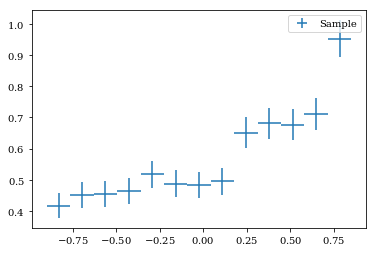

In [27]:
hist2 = histogram(data2)
hist2.plot(fmt='none',label='Sample')
plt.legend();

Maximum log-likelihood: 1062.173
Parameters, uncertainties, covariance:
 p0: 0.51 +/- 0.07	0.01	0.01
 p1: 0.38 +/- 0.07	0.01	0.01


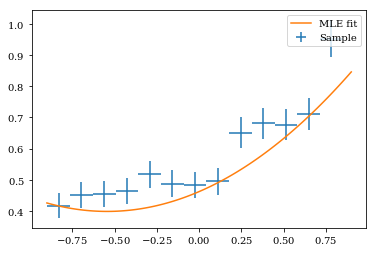

In [28]:
mle2 = mlefit(pdf2,data2,(0,0))
hist2.plot(fmt='none',label='Sample')
xrng2 = np.linspace(-.9,.9,100)
mle.plot(xrng2,label='MLE fit')
print(mle2)
plt.legend();

Again, we fix $\alpha=0.5$ and find the confidence levels of $\beta$

In [29]:
psb = simvar(lambda d, beta : pdf2(d,0.5,beta),
             lambda r, beta : invcdf2(r,0.5,beta),
             mle2.p[1],500,2000)
showcl(psb,['beta'])

beta  (0.391,0.107) 1-sigma CL: 0.289-0.501 (data) 0.289-0.500 (hist)


## Confidence contours
### Direct evaluation from Hessian

Suppose the uncertainty on the parameters $\alpha,\beta$ are given by $\delta_\alpha,\delta_\beta$, respectively.  Then these uncertainties defines a rectangle in $\alpha,\beta$ space.  

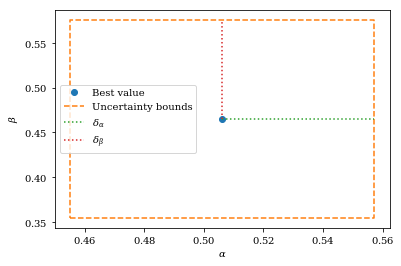

In [30]:
plt.plot(*mle.p,'o',label='Best value')
rect = np.array([(mle.p[0]+a*mle.e[0],mle.p[1]+b*mle.e[1]) for 
                 a, b in [[-1,-1],[1,-1],[1,1],[-1,1],[-1,-1]]])
aline = np.array([mle.p,mle.p + mle.e[0]*np.array([1,0])])
bline = np.array([mle.p,mle.p + mle.e[1]*np.array([0,1])])
plt.plot(rect[:,0],rect[:,1],'--',label='Uncertainty bounds')
plt.plot(aline[:,0],aline[:,1],':',label=r'$\delta_\alpha$')
plt.plot(bline[:,0],bline[:,1],':',label=r'$\delta_\beta$')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.legend()

This, however is _not_ our uncertainty contour. Rather, the contour we are after is an ellipsis, as is evident from the scatter plot we did above.   

If we know the correlation 

$$\rho_{\alpha\beta} = \frac{c_{\alpha,\beta}}{\sqrt{c_{\alpha}c_{\beta}}}\quad,$$ 

where $c_{xy}$ is the covariance of $x,y$ (variance of $x$ if $y=x$), then the ellipsis is described by the equation ([see here](https://math.stackexchange.com/questions/2308198/ellipse-in-a-rectangle))

\begin{align*}
\frac{\alpha^{2}}{\delta_{\alpha}^{2}}+\frac{\beta^{2}}{\delta_\beta^{2}}-\frac{2\alpha\beta}{\delta_\alpha\delta_\beta}\rho&=1-\rho^{2}\quad.
\end{align*}

We can rewrite the above a little simpler.  First of all the major and minor axes radii $a,b$ are given by 

$$a = \sqrt{1+\rho}\quad b=\sqrt{1-\rho}\quad,$$

and we must rotate the ellipsis by $45^{\circ}$, scale by $n\delta_\alpha,n\delta_\beta$, and translate to the found values.  Thus, our parametric curve for the $n\sigma$ contour becomes 

\begin{align*}
\begin{bmatrix} x\\ y\end{bmatrix} &=
\begin{bmatrix} 
n\delta_\alpha\left(\sqrt{1+\rho}\cos t\cos 45^{\circ}-\sqrt{1-\rho}\sin t\sin 45^{\circ}\right)\\
n\delta_\beta \left(\sqrt{1+\rho}\cos t\sin 45^{\circ}+\sqrt{1-\rho}\sin t\cos 45^{\circ}\right)\\
\end{bmatrix}
+\begin{bmatrix}\hat\alpha\\\hat\beta\end{bmatrix}\\
&= 
\frac{n}{\sqrt{2}}
\begin{bmatrix} 
\delta_\alpha\left(\sqrt{1+\rho}\cos t-\sqrt{1-\rho}\sin t\right)\\
\delta_\beta\left(\sqrt{1+\rho}\cos t+\sqrt{1-\rho}\sin t\right)\\
\end{bmatrix}
+\begin{bmatrix}\hat\alpha\\\hat\beta\end{bmatrix}\\
\end{align*}

0.43527516845485364 Maximum log-likelihood: 1216.938
Parameters, uncertainties, covariance:
 p0: 0.51 +/- 0.05	0.00	0.00
 p1: 0.46 +/- 0.11	0.00	0.01


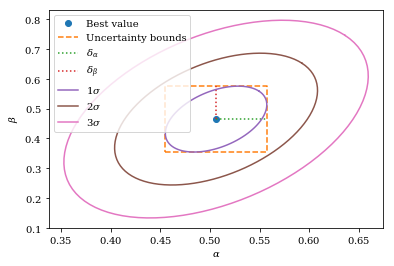

In [31]:
def nsigma_contour(a,b,ea,eb,rho,n=1):
    from numpy import array, sqrt, linspace, pi, cos, sin
    va  = sqrt(1+rho)*array([ 1,  1])#[np.newaxis,:]
    vb  = sqrt(1-rho)*array([-1,  1])#[np.newaxis,:]
    cc  = array([a,b])
    t   = linspace(0,2*pi,100)[:,np.newaxis]
    cnt = n/sqrt(2)*(cos(t)*va - sin(t)*vb)
    cnt[:,0] *= ea
    cnt[:,1] *= eb 
    cnt      += cc
    # cnt = np.array([cc+cos(tt)*va+sin(tt)*vb for tt in t])
    return cnt

plt.plot(*mle.p,'o',label='Best value')
plt.plot(rect[:,0],rect[:,1],'--',label='Uncertainty bounds')
plt.plot(aline[:,0],aline[:,1],':',label=r'$\delta_\alpha$')
plt.plot(bline[:,0],bline[:,1],':',label=r'$\delta_\beta$')

rho = mle.cov[0,1]/(mle.e[0]*mle.e[1])
print(rho,mle)
for n in range(1,4):
    cont = nsigma_contour(*mle.p,*mle.e,rho,n)
    plt.plot(cont[:,0],cont[:,1],'-',label=fr'${n}\sigma$')
    
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.legend();

Here, we used the covariance matrix provided to us by the minimisation routine.  If a minimisation routine does not provide that information, we can still estimate the correlation coefficient $\rho$ via a parameteric bootstrap, as outlined above.

### Evaluation using log-likelihood landscape 

To see the connection to the log-likelihood landscape, we map this out as we did in a previous exercise. 

Maximum log-likelihood: 1216.938
Parameters, uncertainties, covariance:
 p0: 0.51 +/- 0.05	0.00	0.00
 p1: 0.46 +/- 0.11	0.00	0.01
1216.938487749665
[1217.43848775 1218.93848775 1221.43848775]


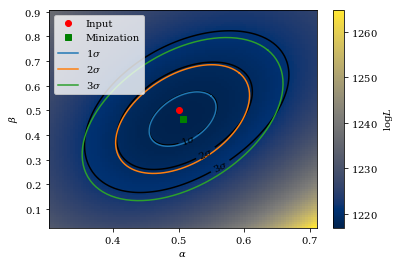

In [32]:
ne = 4
rngs = [np.linspace(pp-ne*ee,pp+ne*ee,100) 
        for pp, ee in zip(mle.p,mle.e)]
malpha, mbeta = np.meshgrid(*rngs)
data3   = data[:,np.newaxis,np.newaxis]
malpha3 = malpha[np.newaxis,:,:]
mbeta3  = mbeta[np.newaxis,:,:]

def nllh(data,f,args):
    return np.log(f(data,*args)).sum(axis=0)

mle     = mlefit(pdf,data,(0,0))
print(mle)
gllh    = mle.llh((malpha3,mbeta3),data3)
mllh    = -mle.nllh
print(mllh)

nsig = (1,2,3) 
fsig = np.array([5.92, 3.09, 1.15])
fsig = np.array([1/2*n**2 for n in nsig])
lvls = mllh+fsig
print(lvls)

bg = plt.pcolor(malpha,mbeta,gllh)
cs = plt.contour(malpha,mbeta,gllh,lvls,colors='k')
plt.clabel(cs,colors='k',
           fmt={l:r'${}\sigma$'.format(ns) 
                   for l, ns in zip(lvls,nsig)})

plt.plot(talpha,tbeta,'or',label='Input')
plt.plot(*mle.p,'sg',label='Minization')

for n,f in zip(nsig,fsig):
    cont = nsigma_contour(*mle.p,*mle.e,rho,n)
    plt.plot(cont[:,0],cont[:,1],'-',label=fr'${n}\sigma$')

plt.colorbar(bg,label=r'$\log L$')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

plt.legend()

## A given data set

A data set with two experiments is available.   We load the data 

In [33]:
data3 = np.genfromtxt('MLE_Variance_data.txt')

The data set contains two experiments - one in each column.  Let us histogram them separately and plot the distributions 

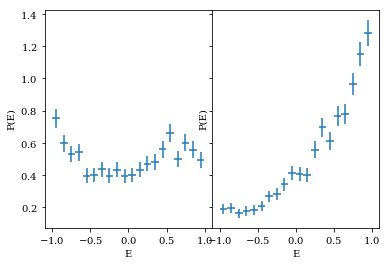

In [34]:
hist1 = histogram(data3[:,0],20)
hist2 = histogram(data3[:,1],20)

fig, ax = plt.subplots(ncols=2,sharey=True,gridspec_kw=dict(wspace=0))
for hh, a in zip([hist1,hist2],ax):
    hh.plot(fmt='none',ax=a,label='Data')
    a.set_xlabel('E')
    a.set_ylabel('P(E)')

We want to fit our PDF over the range $E\in[-1,1]$, so we need to re-`lambdify` our PDF and inverse CDF. 

In [35]:
def pdf3(x,alpha,beta):
    return (1+alpha*x+beta*x**2)/2/(beta/3+1)

Now we're set up to do MLE fits of the PDF to the data just read in. 

In [36]:
p0s  = [[0,0],[0,0]]
mle3 = [mlefit(pdf3,d,p0) for d,p0 in zip(data3.T,p0s)]

We plot the data and the fits and calculate the reduced $\chi^2$ as well as the fit probability ($p$-value). 

Maximum log-likelihood: 1368.436
Parameters, uncertainties, covariance:
 p0: 0.02 +/- 0.71	0.50	0.16
 p1: 0.54 +/- 0.23	0.16	0.05
Maximum log-likelihood: 981.198
Parameters, uncertainties, covariance:
 p0: 1.38 +/- 0.06	0.00	0.00
 p1: 0.87 +/- 0.10	0.00	0.01


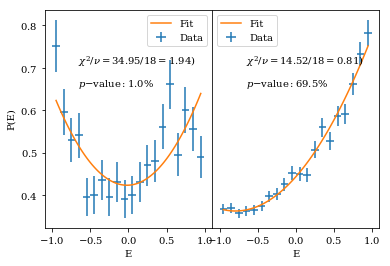

In [37]:
fig, ax = plt.subplots(ncols=2,sharey=False,gridspec_kw=dict(wspace=0))
xrng3 = np.linspace(-1,1,100)
for hh, a, f, p0 in zip([hist1,hist2],ax,mle3,p0s):
    hh.plot(fmt='none',ax=a,label='Data')
    f.plot(xrng,label='Fit',ax=a)
    
    chi2 = (((hh.y - f.f(hh.x,*f.p))/hh.e)**2).sum()
    nu   = len(hh.y) - len(f.p)
    pv   = sp.stats.chi2.sf(chi2,nu)
    
    a.text(.2,.75,r'$\chi^2/\nu={:.2f}/{}={:.2f})$'
           .format(chi2,nu,chi2/nu),
           transform=a.transAxes)
    a.text(.2,.65,r'$p\mathrm{{-value}}: {:.1f}\%$'
           .format(pv*100),transform=a.transAxes)
    
    a.set_xlabel('E')
    a.legend()
    
    print(f)
    
ax[0].set_ylabel('P(E)')
ax[1].set_yticks([]);

The fit on the left hand side is pretty awful with a very low probability, while the one on the right is a little too good ($p$-value larger than $50\%$). 